In [1]:
#%%bash 
#export SUDO_ASKPASS=/Applications/Utilities/XQuartz.app/Contents/MacOS/X11
#ln -sfhv /Library/Frameworks/R.framework/Versions/3.3 /Library/Frameworks/R.framework/Versions/Current

In [1]:
import sys
import os

#%load_ext rpy2.ipython
#%R require(ggplot2)

In [2]:
from deeplate.MMdata import MMData 
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.ndimage as nd

from skimage.measure import label, regionprops
from skimage import morphology
from skimage.color import label2rgb
import pandas as pd

In [3]:
import deeplate.platesegmenter as ps

/scicore/home/nimwegen/witzg/DeepPlateSegmenter/venv-deeplate/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
#folder = '/Volumes/MusiqueHD/201710126_lowerbound'
folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170126/201710126_lowerbound/'
#folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170330/20170330_highmed_1/'

In [5]:
#weights_folder  = '/Users/guillaume/Desktop/PostdocBasel/PlateSegmenter_Python_Git/DeepPlate/Learn201710126/'
weights_folder  = '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_subset_stack2/'

In [6]:
folder_to_save = '/scicore/home/nimwegen/witzg/DeepPlateAnalysis/'

In [7]:
MMobj = MMData(folder = folder)
print(MMobj.channels)

['GFP', 'DIA (GFP)']


In [8]:
#based on the above outpout set fluo and bright field channels
fluo_ch = 0
bf_ch = 1

In [9]:
#load deep learning model and weights
plate_model = ps.get_unet(10, 304,304)
plate_model.load_weights(weights_folder+'weights.h5')

In [10]:
#get metadata
z_step = MMobj.get_zstep()
positions, well = MMobj.get_position_names()
well_index = np.ravel([[x for x in range(well.shape[0]) if well[x] in y] for y in positions])
well_str = well[well_index]

In [26]:
positions.index("C2-Site_1")

37

In [12]:
mid = (MMobj.num_planes[bf_ch]-1)/2

In [13]:
postovisit = np.arange(0,len(positions),6)

In [17]:
postovisit = np.arange(len(positions))

1/1 [==============================] - 0s 364ms/step


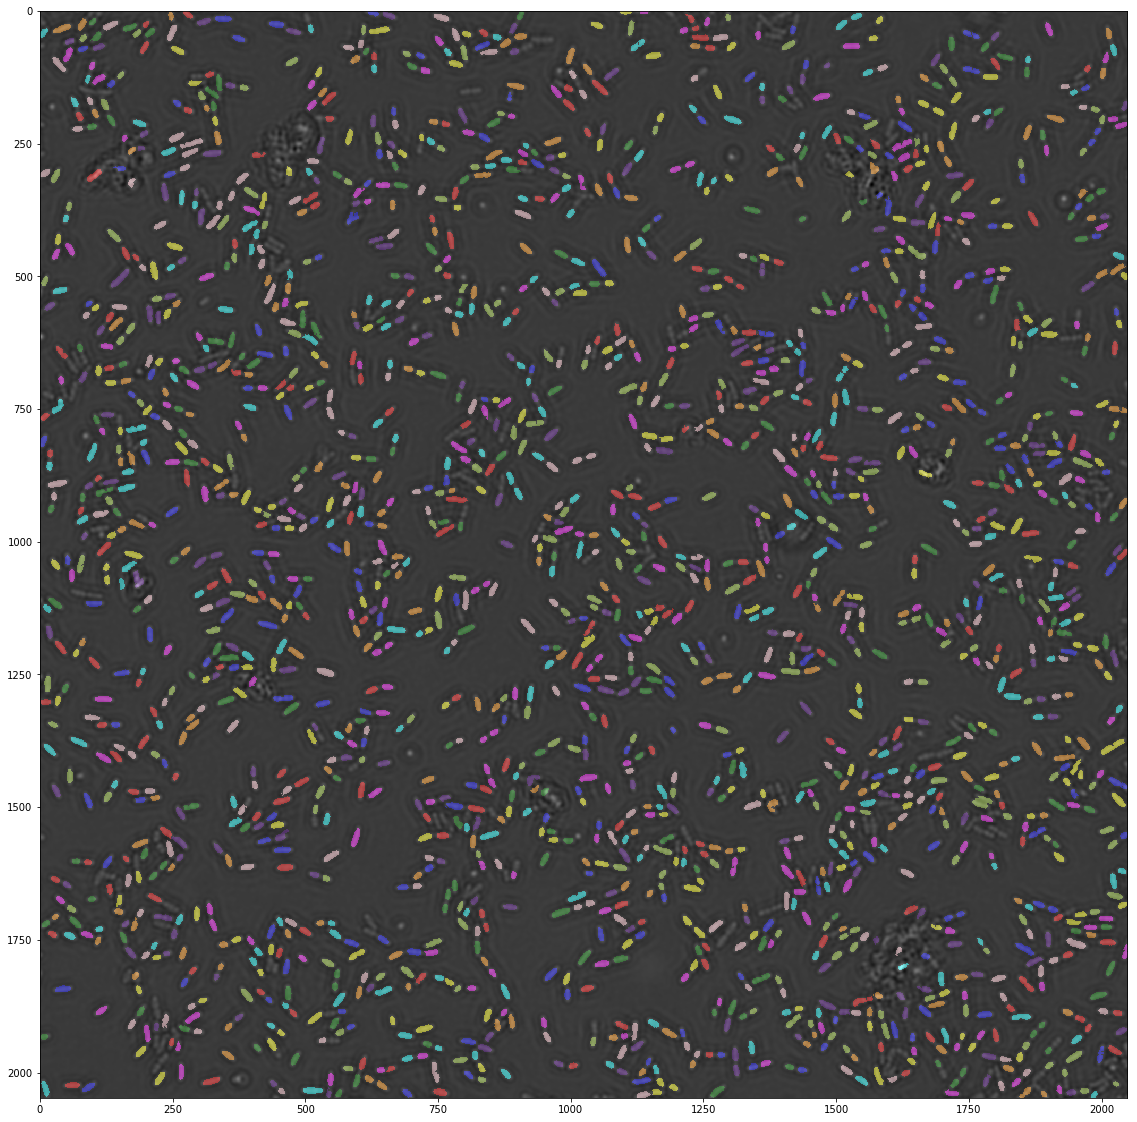

In [27]:
#create folder to save data
if not os.path.exists(folder_to_save):
    os.makedirs(folder_to_save)

#do the segmentation
for i in range(37,38):#range(len(positions)):
    
    #load bf stack
    #stack = MMobj.get_stack(frame=0,channel=bf_ch,position=i, compress = 1)
    stack = np.empty((MMobj.height,MMobj.width, 10))
    disp = [-10,0,10]
    for j in range(10):
        plane = mid-5+j
        stack[:,:,j] = MMobj.get_image(frame=0,channel=bf_ch,plane = plane,position=postovisit[i], compress = 1)
        stack[:,:,j] = nd.gaussian_filter(stack[:,:,j],3)
    
    meanstack = np.mean(stack,axis =2)
    for m in range(stack.shape[2]):
        stack[:,:,m] = stack[:,:,m]-meanstack
    
    
    stack = stack/np.std(stack)
    
    #load fluo image
    im_fluo = MMobj.get_stack(frame=0,channel=fluo_ch,position=postovisit[i], compress = 1)[:,:,0]
    
    complete = np.empty((MMobj.height,MMobj.width))
    complete_proba = np.empty((MMobj.height,MMobj.width))
    
    topad = 24
    stack = np.pad(stack,((topad,topad),(topad,topad),(0,0)),mode = 'constant')
    for k in range(8):
        for m in range(8):
            
            
            stack_cur = stack[k*256:(k+1)*256+2*topad,m*256:(m+1)*256+2*topad,:]

            plate_im = stack_cur[np.newaxis,...]
            plate_im_mask = plate_model.predict(plate_im, verbose=1)
            plate_im_mask = np.reshape(plate_im_mask,[256+2*topad,256+2*topad])

            #threshold deepe learning segmentation and clean resulting mask
            #plate_im_mask2 = plate_im_mask.copy()
            #plate_im_mask2[plate_im_mask2<0.1]=0
            #plate_im_mask2[plate_im_mask2>0.1]=1

            #complete[k*256:(k+1)*256,m*256:(m+1)*256] = plate_im_mask2
            complete_proba[k*256:(k+1)*256,m*256:(m+1)*256] = plate_im_mask[topad:-topad,topad:-topad]
    
    stack = stack[topad:-topad,topad:-topad,:]
    complete = complete_proba.copy()
    
    complete[complete<0.2]=0
    complete[complete>0.2]=1
    masklab = morphology.label(complete)
    cellinfo = regionprops(masklab, im_fluo)  
    cellinfo2 = regionprops(masklab, complete_proba)  
    newMask = np.zeros(masklab.shape)
    for x in range(len(cellinfo)):
        c = cellinfo[x]
        c2 = cellinfo2[x]
        if (c.label>0)&(c.area>100)&(c.area<10000)&(c.solidity>0.8)&(c.eccentricity>0.6)&(c2.max_intensity>0.8):
            newMask[masklab==c.label]=1
    
    #calculate local properties
    
    cell_info = regionprops(label(complete),im_fluo)
    
    mean_int = [x.mean_intensity for x in cell_info]
    posx = [x.centroid[0] for x in cell_info]
    posy = [x.centroid[1] for x in cell_info]
    #create a dataframe
    cell_struct = {'mean_fluo':mean_int,'posx': posx, 'posy': posy}
    cell_frame = pd.DataFrame(cell_struct)
    
    cell_frame.to_csv(folder_to_save+positions[i]+'.csv')
    
    #save image
    fig, ax = plt.subplots(figsize=(20,20))
    plt.imshow(stack[:,:,0],cmap='gray')
    plt.imshow(label2rgb(label(newMask),bg_label=0),alpha = 0.4)
    plt.show()
    fig.savefig(folder_to_save+positions[i]+'seg.png')

In [23]:
cell_info = regionprops(label(complete),complete_proba)

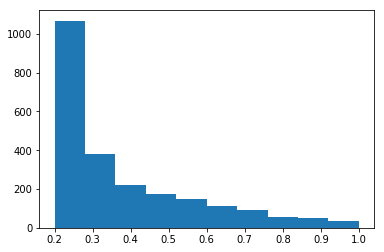

In [24]:
plt.hist([c.max_intensity for c in cell_info])
plt.show()


In [15]:
complete = complete_proba.copy()
    
complete[complete<0.2]=0
complete[complete>0.2]=1
masklab = morphology.label(complete)
cellinfo = regionprops(masklab, im_fluo)    
newMask = np.zeros(masklab.shape)
for c in cellinfo:
    if (c.label>0)&(c.area>100)&(c.area<10000):#&(c.mean_intensity>0.5*overall_mean):#&(c.solidity>0.8)&(c.eccentricity>0.6):
        newMask[masklab==c.label]=1

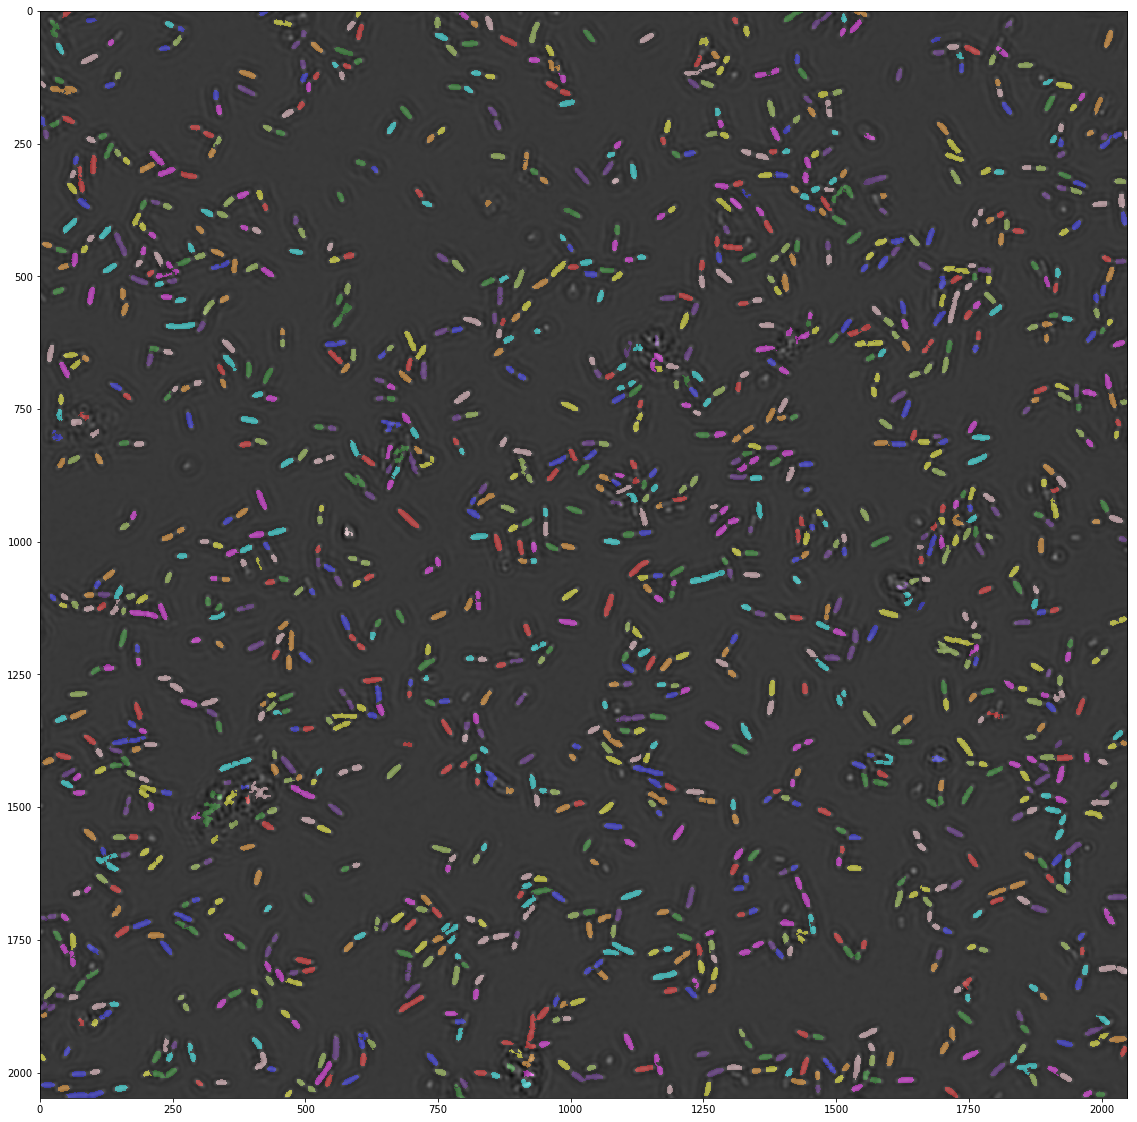

In [16]:
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(stack[:,:,0],cmap='gray')
plt.imshow(label2rgb(label(newMask),bg_label=0),alpha = 0.4)
plt.show()

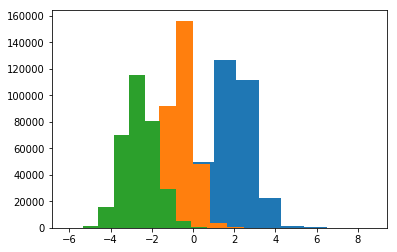

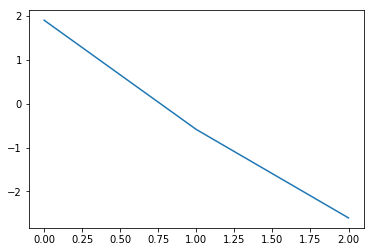

In [54]:
plt.hist(stack[:,:,0][complete==1])
plt.hist(stack[:,:,1][complete==1])
plt.hist(stack[:,:,2][complete==1])
plt.show()
plt.plot([np.mean(stack[:,:,i][complete==1]) for i in range(3)])
m,b = np.polyfit([mid-10,mid,mid+10], [np.mean(stack[:,:,i][complete==1]) for i in range(3)], 1)

In [55]:
m

-0.2256417488980487

In [57]:
-b/m

13.094883017645435

In [ ]:
0 = ax+b

In [20]:
stack = MMobj.get_stack( frame=0,channel=0,position=10, compress = 1)

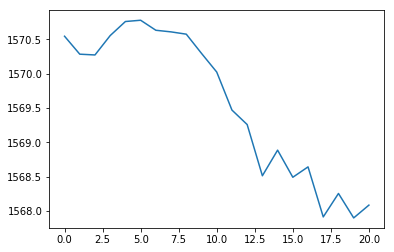

In [27]:
plt.plot([np.mean(stack[:,:,i][newMask==1]) for i in range(stack.shape[2])])
plt.show()

IndexError: index 13 is out of bounds for axis 2 with size 3

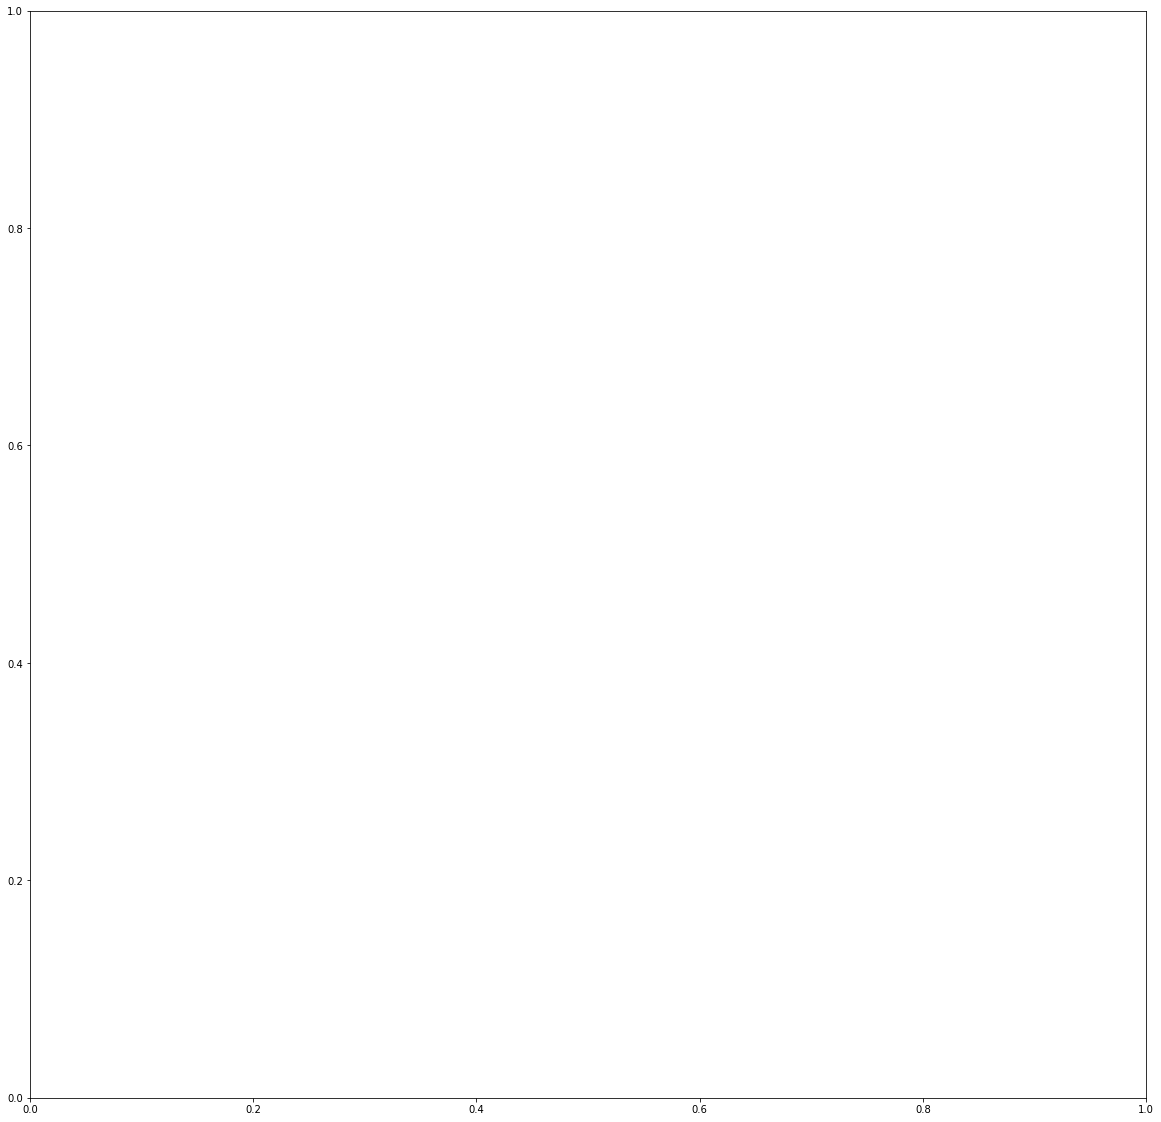

In [50]:
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(stack[:,:,13],cmap='gray')
plt.show()

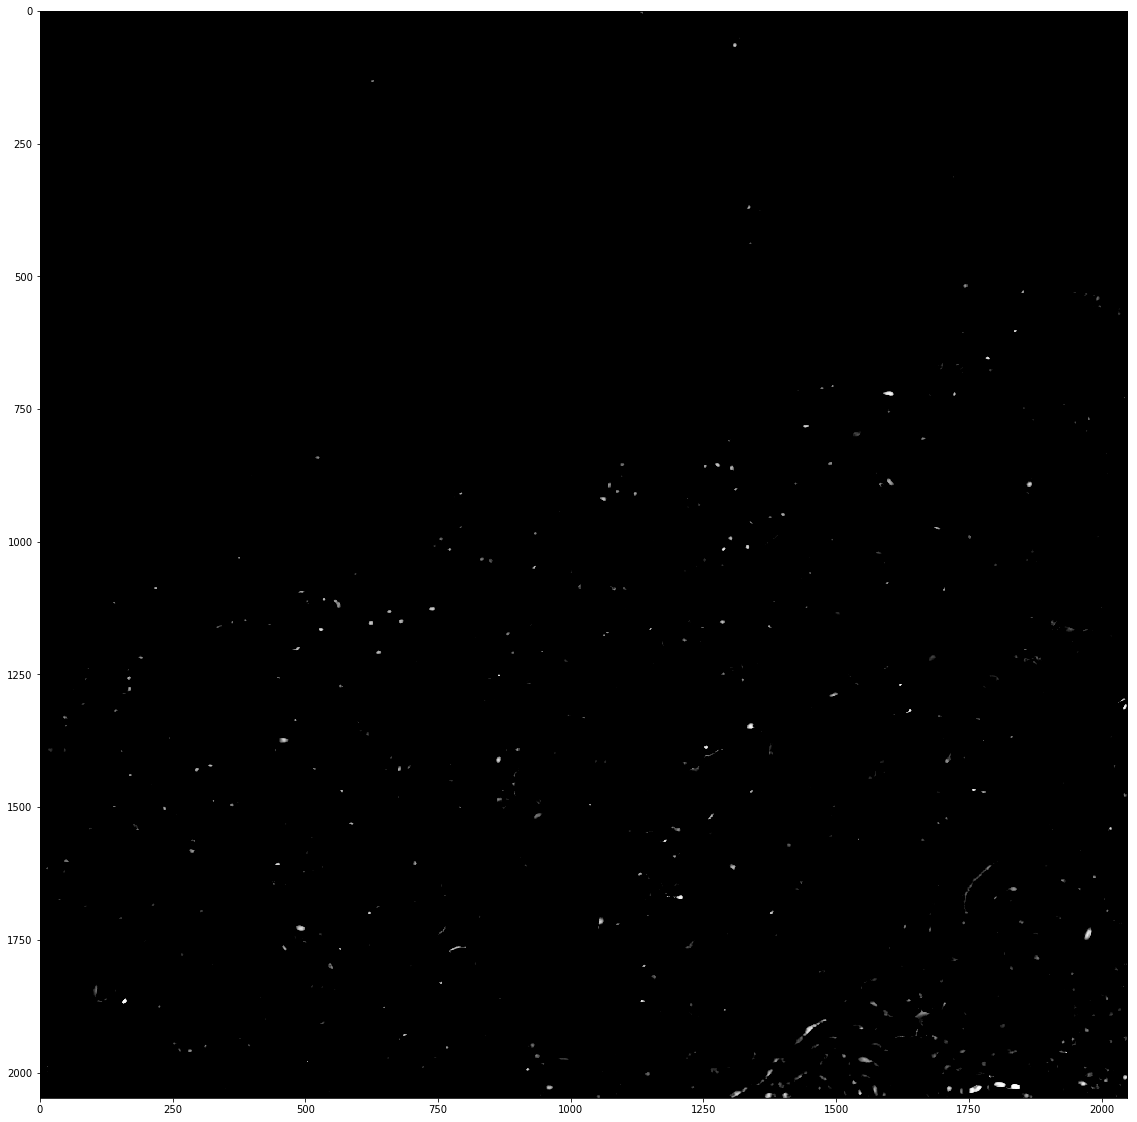

In [21]:
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(complete_proba,cmap='gray',vmin=0.5)
plt.show()

In [158]:
plate_im_mask2 = complete_proba.copy()
plate_im_mask2[plate_im_mask2<0.1]=0
plate_im_mask2[plate_im_mask2>0.1]=1

masklab = morphology.label(plate_im_mask2)
cellinfo = regionprops(masklab, im_fluo)
newMask = np.zeros(masklab.shape)
for c in cellinfo:
    if (c.label>0)&(c.area>100)&(c.area<10000)&(c.mean_intensity>10000):#&(c.solidity>0.8)&(c.eccentricity>0.6):
        newMask[masklab==c.label]=1

In [190]:
cell_info = regionprops(label(newMask),im_fluo)

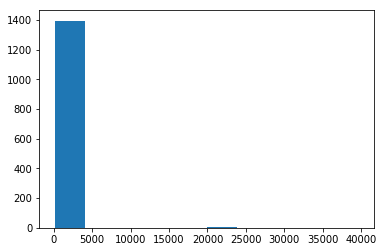

In [191]:
plt.hist([c.mean_intensity for c in cell_info])
plt.show()

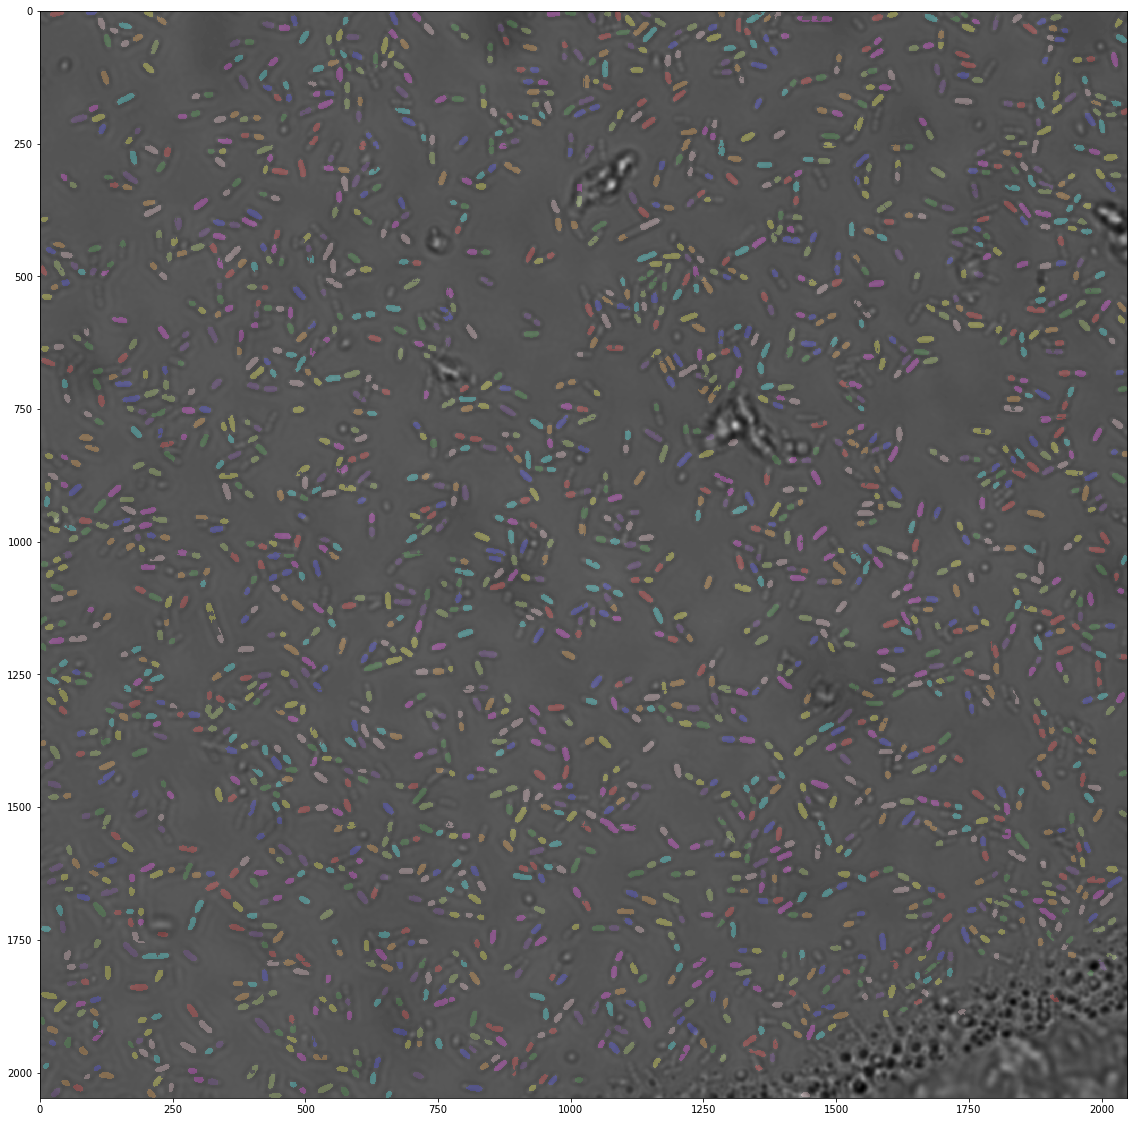

In [161]:
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(stack[:,:,0],cmap='gray')
#plt.imshow(im_fluo,cmap='gray')
plt.imshow(label2rgb(label(newMask),bg_label=0),alpha = 0.2)
plt.show()

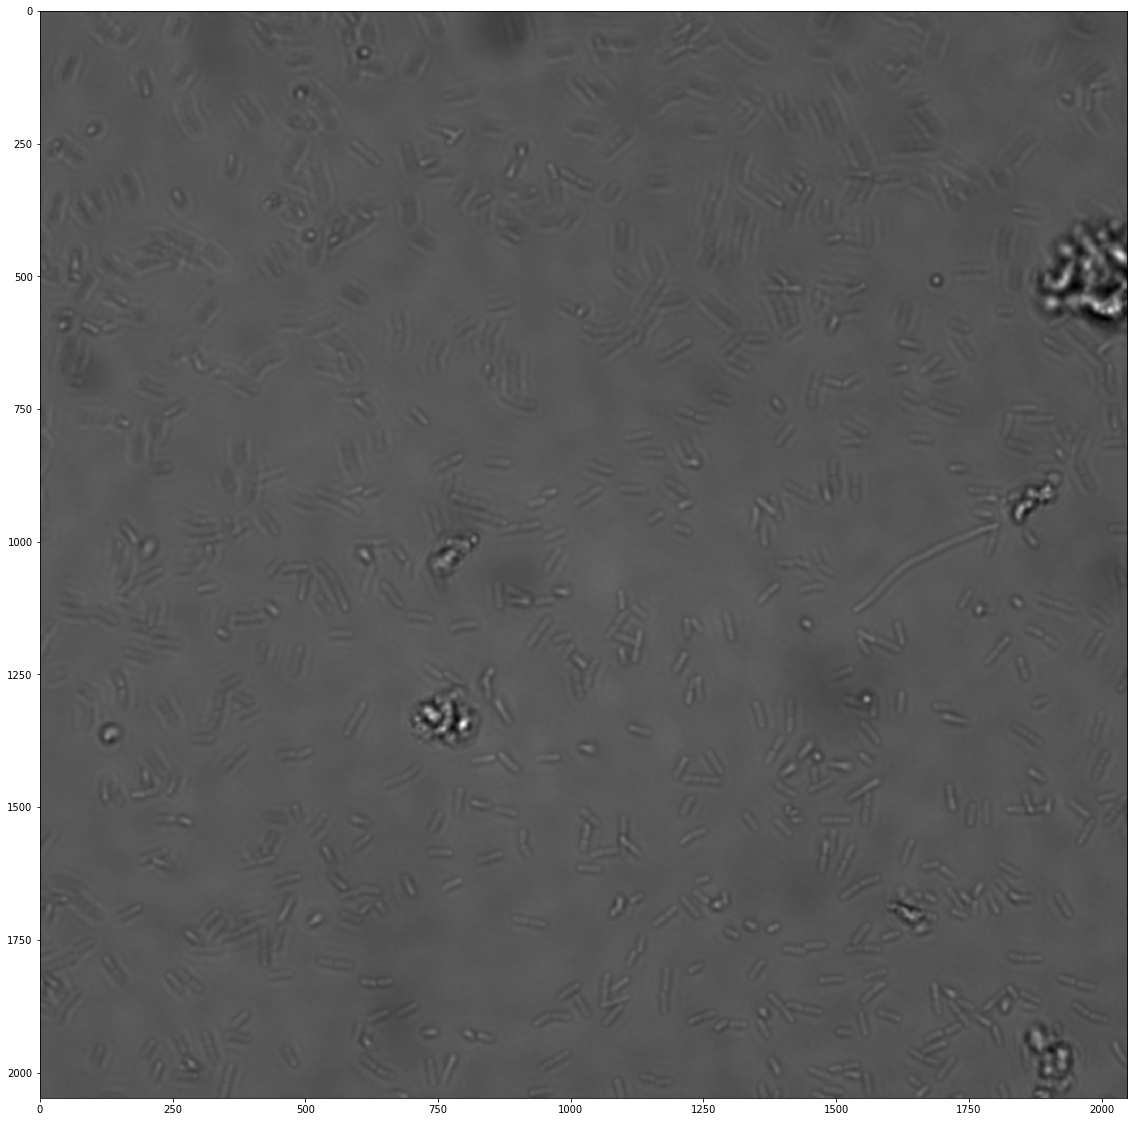

In [63]:
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(stack[:,:,2],cmap='gray')
plt.show()

/scicore/home/nimwegen/witzg/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


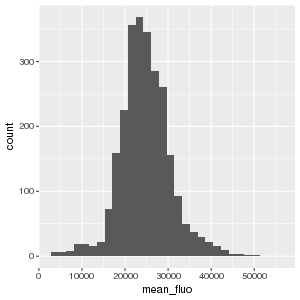

In [18]:
%%R -i cell_frame,folder_to_save -w 300 -h 300 -u px
x<-ggplot(NULL)+
geom_histogram(data=cell_frame,aes(x=mean_fluo))
print(x)

#location<-paste(folder_to_save,cell_frame[0,'position'],'.Rda',sep = "")
#save(cell_frame,file=location)